In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Palaeo-Plotz Function

In [2]:
def stacked_axes(fig, n, squeeze=0.9, proportions=None, topaxis=False,  border=(.1, .1, .8, .8)):
    """
    Function to generate stacked axes for palaeo-type plotz.
    
    Parameters
    ----------
    fig : matploglib.Figure
        The figure you want to put the axes on.
    n : int
        The number of panels you want to plot
    squeeze : float
        The amount you want the plots to overlap.
        overlap > 1 > space between
    proportions : array-like of size (n,)
        The relative size of the panels. If None,
        panels are equal size. If specified, this is
        used to proportion the panels. For example,
        (1, 2, 1, 1) would make the second panel
        twice the size of all the others.
    topaxis : bool
        Whether or not to display an x axis at the top
        of the top panel.
    border : tuple of size (4,)
        The overall space the panels will take up on the
        figure: (left, bottom, width, height) in fractional
        coordinates.
    
    Returns
    -------
    stacked axes that can be used for plotting : list
    """
    if proportions is None:
        proportions = np.full(n, 1.0 / n)
    else:
        proportions = np.array(proportions) / np.sum(proportions)
    
    width = border[2]
    total_height = border[3]
    panel_spaces = total_height * proportions
    panel_heights = total_height * (proportions * squeeze)
    
    axes = []
    left = border[0]
    bottom = border[1]
    for i in range(n):
        axes.append(fig.add_axes((left, bottom, width, panel_heights[i])))
        # record some info about the axes
        if i == 0:
            axes[i].is_first = True
        else:
            axes[i].is_first = False
        if i == n - 1:
            axes[i].is_last = True
        else:
            axes[i].is_last = False
        if i % 2 == 0:
            axes[i].is_even = True
        else:
            axes[i].is_even = False
        bottom += panel_spaces[i]
    
    # format axes
    for ax in axes:
        # remove background colour of panel
        ax.set_facecolor((0,0,0,0))
        ax.spines['top'].set_visible(False)
        if not ax.is_first:
            ax.xaxis.set_visible(False)
            ax.spines['bottom'].set_visible(False)
        
        if ax.is_last and topaxis:
            ax.xaxis.set_visible(True)
            ax.spines['top'].set_visible(True)
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')
        
        if ax.is_even:
            ax.spines['right'].set_visible(False)
        
        else:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.spines['left'].set_visible(False)
    
    return axes

## Example

In [3]:
# make some random data
signals = 5
data = {}

np.random.seed(142)

for s in range(signals):
    data[s] = {}
    # random x data
    data[s]['x'] = np.arange(np.random.uniform(0, 50, 1), 
                             np.random.uniform(70, 120, 1), 
                             np.random.normal(1, .2, 1))
    # random y data
    data[s]['y'] = np.random.uniform(*np.random.uniform(-3, 3, 2), data[s]['x'].size)

In [4]:
data.keys()

dict_keys([0, 1, 2, 3, 4])

Text(0.5,0,'Time (Kya)')

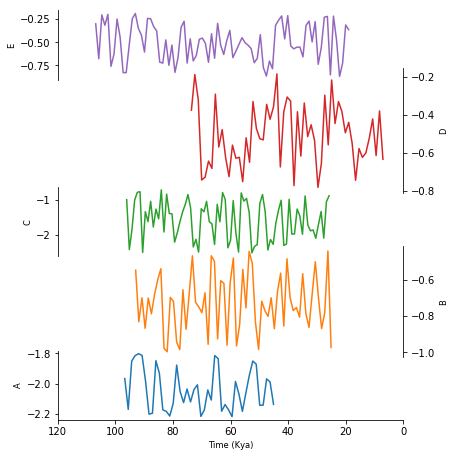

In [5]:
# create a figure
width = 6
panelheight = 1.4
fig = plt.figure(figsize=(width, signals * panelheight))

# create the axes
axs = stacked_axes(fig, 5, squeeze=1.1, topaxis=False, proportions=(1, 1.6, 1, 1.8, 1))

# some labels
labels = 'ABCDE'
# plot the random data!
for i, ax in enumerate(axs):
    ax.plot(data[i]['x'], data[i]['y'], color='C{:}'.format(i))
    # set ylabels
    ax.set_ylabel(labels[i])

    
# note: if you want to change the x axis limits, you need to change it on *all* panels:
for ax in axs:
    ax.invert_xaxis()
    ax.set_xlim(120, 0)
    
axs[0].set_xlabel('Time (Kya)')

Text(0.5,0,'Time (Kya)')

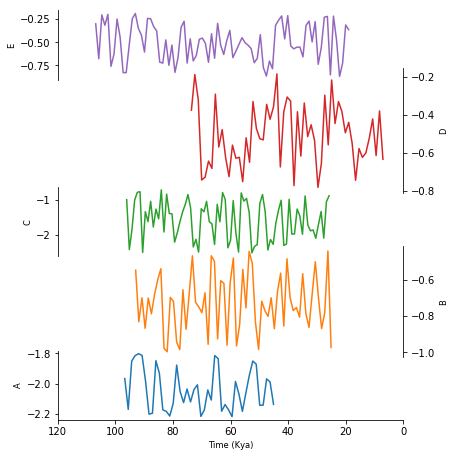

In [6]:
# create a figure
width = 6
panelheight = 1.4
fig = plt.figure(figsize=(width, signals * panelheight))

# create the axes
axs = stacked_axes(fig, 5, squeeze=1.1, topaxis=False, proportions=(1, 1.6, 1, 1.8, 1))

labels = 'ABCDE'

i = 0
ax = axs[i]
ax.plot(data[i]['x'], data[i]['y'], c='C{:}'.format(i))
ax.set_ylabel(labels[i])

i = 1
ax = axs[i]
ax.plot(data[i]['x'], data[i]['y'], c='C{:}'.format(i))
ax.set_ylabel(labels[i])

i = 2
ax = axs[i]
ax.plot(data[i]['x'], data[i]['y'], c='C{:}'.format(i))
ax.set_ylabel(labels[i])

i = 3
ax = axs[i]
ax.plot(data[i]['x'], data[i]['y'], c='C{:}'.format(i))
ax.set_ylabel(labels[i])

i = 4
ax = axs[i]
ax.plot(data[i]['x'], data[i]['y'], c='C{:}'.format(i))
ax.set_ylabel(labels[i])

# note: if you want to change the x axis limits, you need to change it on *all* panels:
for ax in axs:
    ax.invert_xaxis()
    ax.set_xlim(120, 0)
    
axs[0].set_xlabel('Time (Kya)')

## Drawing vertical highlight bars

2 options...
1. Create a new 'dummy' axis in the background, covering the same total area as all other axes.
2. Use zorder to put them in the background, istead of alpha to make them transparrent.

## 1. Background Axis

This one is probably better / more elegant, as you don't have to loop through all axes to draw features on all plots.

In [7]:
def make_background_axis(axs, fig):
    """
    Returns a blank axis that covers the total area of all elements in axs.
    
    Parameters
    ----------
    axs : array-like
        List of axis objects.
    fig : matplotlib.figure
        A figure.
    
    Returns
    -------
    Axis with a white background that covers the entire range of all other 
    axes : matplotlib.axes object
    """
    # make sure axs is iterable (a list of axes)
    if not hasattr(axs, '__iter__'):
        axs = [axs]
    
    # set initial guess coordinates
    left = 1
    bottom = 1
    right = 0
    top = 0
    # loop through all axes, modifying coordinates of
    # background axis so it covers the same area
    for ax in axs:
        p = ax.get_position()                
        if p.x0 < left:
            left = p.x0
        if p.y0 < bottom:
            bottom = p.y0
        if p.x0 + p.width > right:
            right = p.x0 + p.width
        if p.y0 + p.height > top:
            top = p.y0 + p.height
    
    # make and format axis
    dum = fig.add_axes([left, bottom, right - left, top - bottom])
    dum.set_facecolor('white')
    dum.axes.set_frame_on(False)
    dum.xaxis.set_visible(False)
    dum.yaxis.set_visible(False)
        
    dum.set_zorder(-2)
    dum.set_xlim(axs[-1].get_xlim())

    return dum

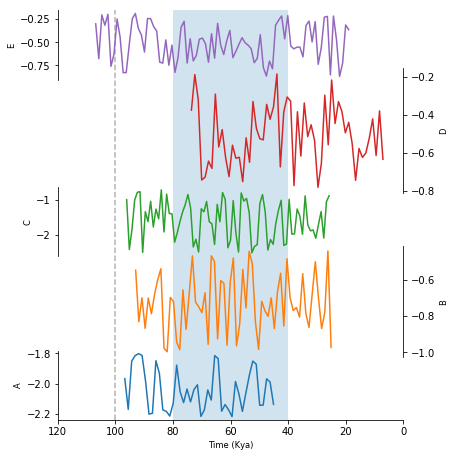

In [8]:
# create a figure
width = 6
panelheight = 1.4
fig = plt.figure(figsize=(width, signals * panelheight))

# create the axes
axs = stacked_axes(fig, 5, squeeze=1.1, topaxis=False, proportions=(1, 1.6, 1, 1.8, 1))

# some labels
labels = 'ABCDE'
# plot the random data!
for i, ax in enumerate(axs):
    ax.plot(data[i]['x'], data[i]['y'], color='C{:}'.format(i))
    # set ylabels
    ax.set_ylabel(labels[i])

    
# note: if you want to change the x axis limits, you need to change it on *all* panels:
for ax in axs:
    ax.invert_xaxis()
    ax.set_xlim(120, 0)
        
axs[0].set_xlabel('Time (Kya)')

# make dummy axis behind other plots
bkg = make_background_axis(axs, fig)
bkg.axvspan(80, 40, alpha=0.2)
bkg.axvline(100, ls='dashed', c=(0,0,0,0.3))

## 2. Zorder instead of Alpha

Text(0.5,0,'Time (Kya)')

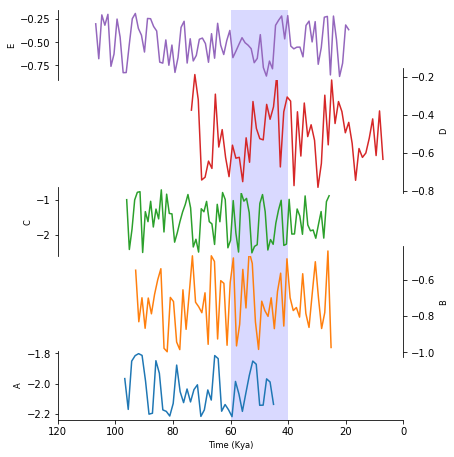

In [9]:
# create a figure
width = 6
panelheight = 1.4
fig = plt.figure(figsize=(width, signals * panelheight))

# create the axes
axs = stacked_axes(fig, 5, squeeze=1.1, topaxis=False, proportions=(1, 1.6, 1, 1.8, 1))

# some labels
labels = 'ABCDE'
# plot the random data!
for i, ax in enumerate(axs):
    ax.plot(data[i]['x'], data[i]['y'], color='C{:}'.format(i))
    # set ylabels
    ax.set_ylabel(labels[i])

    
# note: if you want to change the x axis limits, you need to change it on *all* panels:
for ax in axs:
    ax.invert_xaxis()
    ax.set_xlim(120, 0)
    
    ax.axvspan(40, 60, facecolor=(.85, .85, 1), zorder=-2)
    
axs[0].set_xlabel('Time (Kya)')


## Adding a secondary axis

Code inspired by [this](https://matplotlib.org/examples/pylab_examples/multiple_yaxis_with_spines.html).

(11.326849450135294, 12.112222059206813)

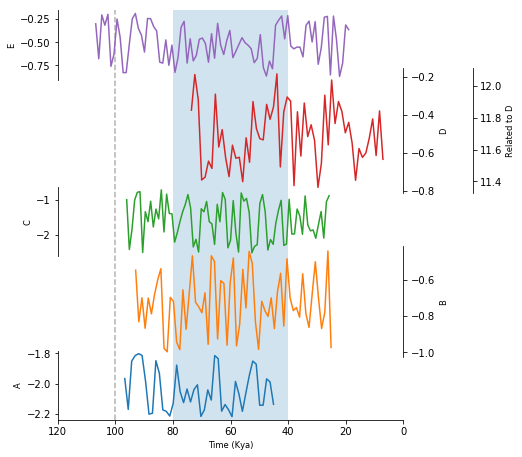

In [10]:
# create a figure
width = 6
panelheight = 1.4
fig = plt.figure(figsize=(width, signals * panelheight))

# create the axes
axs = stacked_axes(fig, 5, squeeze=1.1, topaxis=False, proportions=(1, 1.6, 1, 1.8, 1))

# some labels
labels = 'ABCDE'
# plot the random data!
for i, ax in enumerate(axs):
    ax.plot(data[i]['x'], data[i]['y'], color='C{:}'.format(i))
    # set ylabels
    ax.set_ylabel(labels[i])
    
# note: if you want to change the x axis limits, you need to change it on *all* panels:
for ax in axs:
    ax.invert_xaxis()
    ax.set_xlim(120, 0)
        
axs[0].set_xlabel('Time (Kya)')

# make dummy axis behind other plots
bkg = make_background_axis(axs, fig)
bkg.axvspan(80, 40, alpha=0.2)
bkg.axvline(100, ls='dashed', c=(0,0,0,0.3))

## Create a secondary axis on the 'D' panel.

# 1. add a new blank axis at the same position as D axis
parent = axs[3]  # define 'parent' axis
child = fig.add_axes(parent.get_position())  # create a 'child' axis at the same position
child.patch.set_visible(False)  # remove background
child.xaxis.set_visible(False)  # remove xticks
for sp in child.spines.values():  # remove border lines
    sp.set_visible(False)

# 2. format new axis
child.yaxis.tick_right()  # move yaxis to right
child.yaxis.set_label_position('right')  # move axis labe lto right
child.spines['right'].set_visible(True)  # make the axis visible
child.spines['right'].set_position(("axes", 1.2))  # movit it out away from the other plots

# 3. Labels and limits
child.set_ylabel('Related to D')  # set the axis label
# set the axis limit. If the two axes are related (which they should be), the
# easiest way to do this is with a function:
parent_y = np.array(parent.get_ylim())
child.set_ylim(parent_y * 1.2 + 12.3 )
